In [1]:
# Name: Seyyid Osman Sevgili        
# ID: 504221565

# Hw I - Fully Connected Neural Networks (100 Points)

We covered artificial neural networks with multiple hidden layers in class. In this assignment, you will implement Fully Connected Neural Network (FCN) components in order to perform a supervised classification task.

The dataset you are going to work with are : (i) for development of your code, you will use diamonds dataset for classification; (ii) for actual training and testing of your implementation in this assignment.

Usage of any built-in functions for code parts that you are asked to write are not allowed. We provide a skeleton code on which to build on your own architecture. In the Layer class, there are two important methods, named as forward and backward. Almost everything you will use in this assignment is derived from this class. We will follow PyTorch-like architecture in the skeleton code.

**Please do not modify the following cells. We will use them for the evaluation of your homeworks. **

**You should modify and fill in the code under DL/layers.py, which includes functions such as layer.NNLayer.* ...**



In [2]:
import numpy as np
from DL import bases, layers, activations, losses, classifiers, optimizers
from DL.checker.checks import *
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
%load_ext autoreload
%autoreload 2

**You should read:** https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b

### To auto-reload your modules from the *.py files, re run the following cell

In [4]:
%reload_ext autoreload
%autoreload 2

## 1 Layers, Activations and Optimizers

In the `Layer` class, there are two important methods, named as `forward` and `backward`. Almost everything you will use in this assignment is derived from this class. You will be programming in Python language.

**Don't forget to test your implementation by using the cells below!**



### a. Affine Layer 

In this layer, we basically implement the hidden layers of neural nets. Each neuron (building block of neural networks) is a just logistic regression classifier itself, but stacking these neurons make them powerful to implement any function.
We are going to implement our affine layer 

Go under `DL/layers.py` and find `AffineLAyer` class. Implement the forward pass for Affine layer which is formulated as follows:

$ z = W x + b $ 

#### Forward pass

In [5]:
num_inputs = 10
input_shape = (4, 7, 2) 
output_dim = 3

input_size = num_inputs * np.prod(input_shape)  # 560
weight_size = output_dim * np.prod(input_shape) # 168
affineLayer = layers.AffineLayer(input_size, weight_size)  

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)  # (10, 4, 7, 2)
affineLayer.W = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)  # (560, 3)
affineLayer.b = np.linspace(-0.3, 0.1, num=output_dim)  # (3,)

out = affineLayer.forward(x)
relError = rel_error(out, "affine_forward")

print('Testing forward method of affine layer:')
print(f'difference: {relError}')
assert 1e-6 > relError

Testing forward method of affine layer:
difference: 8.825372662436368e-08


#### Backward pass : 
Go under `DL/layers.py` and find `AffineLayer` class. Implement the backward pass for Affine layer.

In [6]:
np.random.seed(250)
num_inputs = 7
input_shape = (4, 10, 3)
output_dim = 8

input_size = num_inputs * np.prod(input_shape)  # 840
weight_size = output_dim * np.prod(input_shape)  # 960
affineLayer = layers.AffineLayer(input_size, weight_size)  

x = np.random.randn(13, 2, 3) 
affineLayer.W = np.random.randn(6, 5)
affineLayer.b = np.random.randn(5)
dout = np.random.randn(13, 5)

dx_num = grad_check(affineLayer.forward, x, dout)
dw_num = grad_check(lambda _ : affineLayer.forward(x), affineLayer.W, dout)
db_num = grad_check(lambda _ : affineLayer.forward(x), affineLayer.b, dout)

affineLayer.forward(x)
dx, dw, db = affineLayer.backward(dout)

# Errors should be around 1e-6 at least
print('Testing backward method of affine layer:')
print(f'dx error: {rel_error(dx_num, dx)}')
print(f'dw error: {rel_error(dw_num, dw)}')
print(f'db error: {rel_error(db_num, db)}')

assert 1e-6 > rel_error(dx_num, dx) 
assert 1e-6 > rel_error(dw_num, dw) 
assert 1e-6 > rel_error(db_num, db) 

Testing backward method of affine layer:
dx error: 1.2583719079635203e-09
dw error: 1.5263035322254397e-09
db error: 5.183871742878614e-10


### b. Activation Layers 

Go under `DL/activations.py` and find `ExponentialLinearUnit` class. Implement the forward pass for ExponentialLinearUnit:

ELU(x) = 
\begin{cases} 
x & \text{if } x > 0 \\
\alpha (e^x - 1) & \text{if } x \leq 0
\end{cases}


#### Forward pass

In [7]:
exponentialLinearUnit = activations.ExponentialLinearUnit(1.0)
x = 2*(np.array([0,1,3,4,-1,2,4,1773,-1773, 1.3, .4, -.1]).reshape(3, -1))
out = exponentialLinearUnit.forward(x)
import numpy as np

# Change print format settings
np.set_printoptions(suppress=True, precision=3)
print(np.array(out))

# Compare your output with ours. 
relError = rel_error(out, "ExponentialLinearUnit_forward")
print('Testing forward method of ExponentialLinearUnit layer:')
print(f'Error: {relError}')
assert 1e-6 > relError

[[   0.       2.       6.       8.   ]
 [  -0.865    4.       8.    3546.   ]
 [  -1.       2.6      0.8     -0.181]]
Testing forward method of ExponentialLinearUnit layer:
Error: 2.15099408081792e-10


#### Backward pass

In [8]:
exponentialLinearUnit = activations.ExponentialLinearUnit(1.0)
np.random.seed(1773)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = grad_check(exponentialLinearUnit.forward, x, dout)

exponentialLinearUnit.forward(x)
dx = exponentialLinearUnit.backward(dout)


# The error should be around 2e-11
print('Testing backward method of exponentialLinearUnit layer:')
print(f'dx error: {rel_error(dx_num, dx)}')

Testing backward method of exponentialLinearUnit layer:
dx error: 2.4835501055568096e-11


### c. Softmax classifier  

In multi-class classification task, as we've seen in the class, the softmax loss function is utilized. 
Practically, at the final layer of the network, instead of the standard activation, we utilize softmax function to turn the likelihood of each class into class probabilities. Then, we utilize the cross-entropy loss as the data loss. Below, you implement and return only the data loss component in your overall loss. 

***Implement your loss computation in the function `loss` of the `DL/losses.py`***

You will write forward pass and backward pass for the softmax unit. Below, we evaluate your method by a numerical gradient method.

In [9]:
np.random.seed(1773)
num_classes, num_inputs = 8, 60
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)
softmax = classifiers.Softmax()

def softmax_loss(x,y):
    probs = softmax.forward(x)
    dx = softmax.backward(y)
    loss = losses.loss(probs, y) 
    return loss,dx


loss, dx = softmax_loss(x,y)
print(loss, dx.shape)
dx_num = grad_check(lambda x: softmax_loss(x, y)[0], x)

# The loss should be about 2.0
relError = rel_error(dx_num, dx)
print('Testing softmax_loss:')
print(f'loss: {loss}')
print(f'dx error: {relError}')
assert 3 > loss
assert 1e-6 > relError

2.079497605608044 (60, 8)
Testing softmax_loss:
loss: 2.079497605608044
dx error: 4.742570690031546e-08


### d. Implement RmsProp optimizer 
Implement RmsProp Strategy in 'Rmsprop' classes. Test their correctness using the cell below. 
Implement `RmsProp` class in `DL/optimizers.py`.

In [10]:
np.random.seed(1773)
toyModel = bases.Model()
model_layers = [layers.AffineLayer(10,2, seed=1773), layers.AffineLayer(2,3, seed=1773), classifiers.Softmax()]
toyModel(model_layers)
optimizer = optimizers.RMSprop(model=toyModel, lr=1, beta=0.9, epsilon=1e-8)

x = np.random.randn(3,10)
y = np.array([0,1,2]).reshape(-1)
toyModel.forward(x)
toyModel.backward(y)
optimizer.optimize()

student_out = []
for i in range(2):
    student_out.append(toyModel[i].W)
    student_out.append(toyModel[i].b)
    
for i in range(4):
    layer_name = ["weights", "biases"][i%2]
    relError = rel_error(student_out[i], f"RMSprop_{layer_name}_{i//2}")
    print(f'Testing {layer_name} of {i//2}th layer')
    assert 1e-6 > relError

Testing weights of 0th layer
Testing biases of 0th layer
Testing weights of 1th layer
Testing biases of 1th layer


## 2. Build and test your own model! (85 points)

Below is an example which is implemented using previously defined API. In this example, you will use a subset of diamonds dataset (https://github.com/mwaskom/seaborn-data/blob/master/diamonds.csv). Each instance has 4 features in this subset. You will select a pair of two features and do your experiments on it. 

In [11]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: /Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip


In [12]:
import seaborn as sns
diamonds = sns.load_dataset("diamonds")

# create a subset
diamonds_filtered = (diamonds[diamonds['color'].isin(['E', 'J', 'H'])]).iloc[:500]
diamonds_filtered = diamonds_filtered[['carat','depth', 'table', 'color', 'price']]

# Display the first few rows of the DataFrame
print(diamonds_filtered.head())

   carat  depth  table color  price
0   0.23   61.5   55.0     E    326
1   0.21   59.8   61.0     E    326
2   0.23   56.9   65.0     E    327
4   0.31   63.3   58.0     J    335
5   0.24   62.8   57.0     J    336


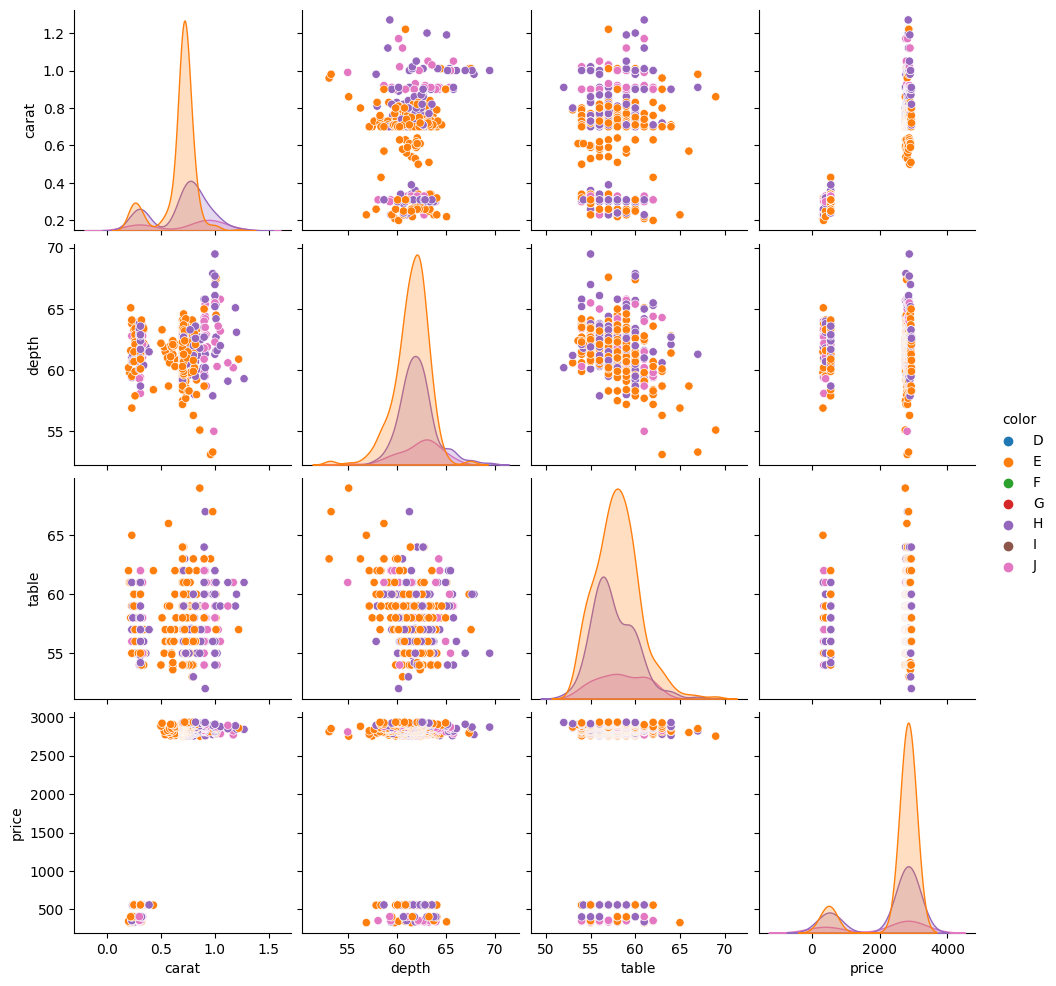

In [13]:
sns.pairplot(diamonds_filtered,hue='color')

### Comment:
Consider any pair of features? Do you think they are linearly separable? 


In [14]:
#comment here. which 2D projections seems easier to work on.
# As we can see from the pairplot, there is no data that is directly linearly seperable. Carat vs depth seems to be the most useful feature to work on.


### Prepare your data 

In [15]:
from sklearn import preprocessing

# choose a pair of features to form data X. Convert the diamonds color label to index label y. 
# Use sklearn.preprocessing.LabelEncoder to convert the color labels to numerical values.
data = diamonds_filtered.copy()

# Drop NANs
data = data.dropna()

# See how much data points you have 
print(data.shape)

# Prepare your data. Choose two feature columns. and get target labels as an integer or one-hot encoded value
# X, y =  # # TODO Get the features and the corresponding classes
le = preprocessing.LabelEncoder()
data['color'] = le.fit_transform(data['color'])

X = data[['carat', 'depth']].values
y = data['color'].values

(500, 5)


### f. Model and Training (15pts) 
Create a one hidden layer multilayer neural network model, train and test. 
* Obtain at least 70% test accuracy in 30 epochs, at most.
* Tune the variables as you wish. 
* For activations, optimizers you can choose any. But the following question asks you to compare cases. 

In [16]:
import pandas as pd

# Complete the code below

model = bases.Model()  # Create a model instance

# The dataset must have 2 features, so the input size of first layer is 2. We have 3 classes, so size of last hidden is 3.
# Each neuron corresponds the likelihood of a class, named P(y=neuron_index|x), where y is class label
# and x is features given.

# Setup the model
# model_layers = a list of layers
model_layers = [
    layers.AffineLayer(2, 64, seed=1773),
    activations.ExponentialLinearUnit(),
    layers.AffineLayer(64, 3, seed=1773),
    classifiers.Softmax(),
]  


model(model_layers)  # Load layers to model object
predictions = np.ones(y.shape[0])  # Number of instances in the diamonds data
train_accs = []
test_accs = []
train_losses = []
test_losses = []


# Shuffle dataset
def create_permutation(x, y):
    perm = np.random.permutation(len(x))
    return x[perm], y[perm]


def train_test_split(X, y, ratio=0.2):
    X, y = create_permutation(X, y)
    split_index = int(len(X) * (1 - ratio))
    X_train, y_train = X[:split_index], y[:split_index]
    X_test, y_test = X[split_index:], y[split_index:]
    return X_train, y_train, X_test, y_test


# Options
preprocessing_on = True
shuffle_on_each_epoch = True
regularization_strength = 0.01
n_epochs = 30
train_test_split_ratio = 0.2
print_every = 1
test_every = 1
test_points = []
if preprocessing_on:
    X = preprocessing.scale(X)
X_train, y_train, X_test, y_test = train_test_split(X, y)
print(X_train.shape, y_train.shape)

optimizer = optimizers.RMSprop(model=model, lr=0.09951285923544048, epsilon=3.7770389463452032e-06)



for epoch in range(n_epochs):
    if shuffle_on_each_epoch:
        X_train, y_train = create_permutation(X_train, y_train)

    # COMPLETE THE CODE BELOW

    softmax_out = model.forward(X_train)

    predictions = np.argmax(softmax_out, axis=1)
    loss = losses.loss(softmax_out, y_train)
    train_acc = np.mean(predictions == y_train)
    train_accs.append(train_acc)
    train_losses.append(loss)

    if epoch % print_every == 0:
        print(f"TRAIN:\tEpoch: {epoch:3d}, Loss: {loss:.5f}, Accuracy: {train_acc:.5f}")

    # call backpropagation
    model.backward(y_train)
    optimizer.optimize()

    # Then complete the testing part.
    if epoch % test_every == 0 or epoch == n_epochs - 1:
        softmax_out = model.forward(X_test)
        predictions = np.argmax(softmax_out, axis=1)
        loss = losses.loss(softmax_out, y_test)
        test_acc = np.mean(predictions == y_test)
        test_losses.append(loss)
        test_points.append(epoch)
        test_accs.extend([test_acc for i in range(test_every)])
        print(f"TEST:\tEpoch: {epoch:3d}, Loss: {loss:.5f}, Accuracy: {test_acc:.5f}")



# softmax_out = model.forward(X_test)
# predictions_test = np.argmax(softmax_out, axis=1)

# softmax_out = model.forward(X_train)
# predictions_train = np.argmax(softmax_out, axis=1)
# activations_results = pd.DataFrame({
#     "predictions_test": np.pad(predictions_test, (0, len(predictions_train) - len(predictions_test)), constant_values=3) ,
#     "predictions_train": predictions_train,
# })
# activations_results.to_csv("results/activation/activations_elu_results.csv", index=False)

# train_results_df = pd.DataFrame(
#     {"epoch": range(n_epochs), "train_loss": train_losses, "train_accuracy": train_accs}
# )

# test_results_df = pd.DataFrame(
#     {
#         "epoch": test_points,
#         "test_loss": test_losses,
#         "test_accuracy": test_accs[: len(test_points)],
#     }
# )

# Save DataFrames to CSV files
# LR Case
# train_results_df.to_csv(f"results/lr/train_results_{optimizer.lr}.csv", index=False)
# test_results_df.to_csv(f"results/lr/test_results_{optimizer.lr}.csv", index=False)

# Activation Function Case
# train_results_df.to_csv(f"results/activation/train_results_sigmoid.csv", index=False)
# test_results_df.to_csv(f"results/activation/test_results_sigmoid.csv", index=False)

(400, 2) (400,)
TRAIN:	Epoch:   0, Loss: 1.63476, Accuracy: 0.38000
TEST:	Epoch:   0, Loss: 6.71324, Accuracy: 0.34000
TRAIN:	Epoch:   1, Loss: 5.93655, Accuracy: 0.30750
TEST:	Epoch:   1, Loss: 4.36278, Accuracy: 0.30000
TRAIN:	Epoch:   2, Loss: 3.63503, Accuracy: 0.38000
TEST:	Epoch:   2, Loss: 0.99840, Accuracy: 0.58000
TRAIN:	Epoch:   3, Loss: 1.02747, Accuracy: 0.59500
TEST:	Epoch:   3, Loss: 0.75212, Accuracy: 0.70000
TRAIN:	Epoch:   4, Loss: 0.90172, Accuracy: 0.61500
TEST:	Epoch:   4, Loss: 0.81926, Accuracy: 0.64000
TRAIN:	Epoch:   5, Loss: 0.85971, Accuracy: 0.63750
TEST:	Epoch:   5, Loss: 0.68515, Accuracy: 0.70000
TRAIN:	Epoch:   6, Loss: 0.83131, Accuracy: 0.63500
TEST:	Epoch:   6, Loss: 0.76036, Accuracy: 0.64000
TRAIN:	Epoch:   7, Loss: 0.81814, Accuracy: 0.63500
TEST:	Epoch:   7, Loss: 0.66379, Accuracy: 0.70000
TRAIN:	Epoch:   8, Loss: 0.80733, Accuracy: 0.64250
TEST:	Epoch:   8, Loss: 0.74242, Accuracy: 0.64000
TRAIN:	Epoch:   9, Loss: 0.80114, Accuracy: 0.64000
TEST:

### OPTUNA Optimization Codes (Extra)

In [ ]:
!pip install optuna

In [ ]:
from itertools import combinations
import optuna
import warnings
warnings.filterwarnings("ignore")

# Shuffle dataset
def create_permutation(x, y):
    perm = np.random.permutation(len(x))
    return x[perm], y[perm]

def train_test_split(X, y, ratio=0.2):
    X, y = create_permutation(X, y)
    split_index = int(len(X) * (1 - ratio))
    X_train, y_train = X[:split_index], y[:split_index]
    X_test, y_test = X[split_index:], y[split_index:]
    return X_train, y_train, X_test, y_test

def objective(trial):
    lr = trial.suggest_float("lr", 1e-5, 0.1, log=True)
    # optimizer_choice = trial.suggest_categorical("optimizer", ["SGDWithMomentum", "RMSprop"])
    # hidden_units1 = trial.suggest_categorical("hidden_units1", [24, 28, 32, 36, 40, 44, 48, 42, 56, 60 , 64, 68, 72, 76])
    hidden_units1 = trial.suggest_categorical("hidden_units1", [8, 16, 32, 64, 128, 256])
    activation_choice = trial.suggest_categorical("activation", ["ReLU", "ELU"])
    # momentum = trial.suggest_float("momentum", 0.5, 0.9) if optimizer_choice == "SGDWithMomentum" else None
    epsilon = trial.suggest_float("epsilon", 1e-8, 1e-4, log=True) 
    features = trial.suggest_categorical("features", list(combinations( ['carat','depth', 'table', 'price'], 2)))
    # regularization_strength = trial.suggest_float("regularization_strength", 1e-6, 1e-2, log=True)

    if activation_choice == "ReLU":
        activation = activations.ReLU
    elif activation_choice == "ELU":
        activation = activations.ExponentialLinearUnit

    model = bases.Model()

    model_layers = [
        layers.AffineLayer(2, hidden_units1, seed=1773),
        activation(),

        layers.AffineLayer(hidden_units1, 3, seed=1773),
        classifiers.Softmax(),
    ]

    model(model_layers)

    optimizer = optimizers.RMSprop(model=model, lr=lr, epsilon=epsilon)

    data = diamonds_filtered.copy()
    data = data.dropna()

    le = preprocessing.LabelEncoder()
    data['color'] = le.fit_transform(data['color'])

    # features = ('depth', 'price')
    X = data[list(features)].values
    y = data['color'].values

    predictions = np.ones(y.shape[0])  # Number of instances in the diamonds data
    train_accs = []
    test_accs = []
    train_losses = []
    test_losses = []

    preprocessing_on = True
    shuffle_on_each_epoch = True
    regularization_strength = 0.05
    n_epochs = 30
    train_test_split_ratio = 0.2
    print_every = 1
    test_every = 1
    test_points = []
    if preprocessing_on:
        X = preprocessing.scale(X)
    X_train, y_train, X_test, y_test = train_test_split(X, y)

    best_val = 0
    for epoch in range(n_epochs):
        if shuffle_on_each_epoch:
            X_train, y_train = create_permutation(X_train, y_train)

        softmax_out = model.forward(X_train)

        predictions = np.argmax(softmax_out, axis=1)
        loss = losses.loss(softmax_out, y_train)
        train_losses.append(loss)
        train_acc = np.mean(predictions == y_train)

        model.backward(y_train)
        optimizer.optimize()

        if epoch % test_every == 0 or epoch == n_epochs - 1:
            softmax_out = model.forward(X_test)
            predictions = np.argmax(softmax_out, axis=1)
            loss = losses.loss(softmax_out, y_test)
            test_losses.append(loss)
            test_acc = np.mean(predictions == y_test)

    # return np.mean(train_losses) + np.mean(test_losses)
    return test_acc

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5000)

print("Best hyperparameters:", study.best_params)
print("Best test accuracy:", study.best_value)

### f. Plot the training and test loss curves for diagnostics below (10 pts):



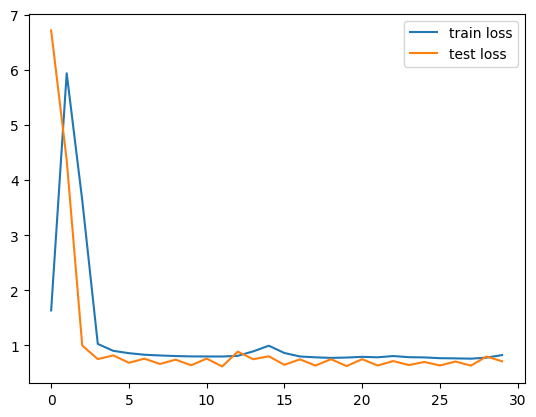

In [17]:
# insert your code below
import matplotlib.pyplot as plt
plt.plot(train_losses, label='train loss')
plt.plot(test_points, test_losses, label='test loss')
plt.legend()
plt.show()


### g1. Compare the performances of at least three different activation functions.  (10 pts)
Comment on the result. 

*** I got similar results on the ELU and RELU however i got bad results with sigmoid since the sigmoid squashes inputs between 0-1 it is more proper on the last layer for the binary classification tasks. ELU and RELU has similar graphs.***

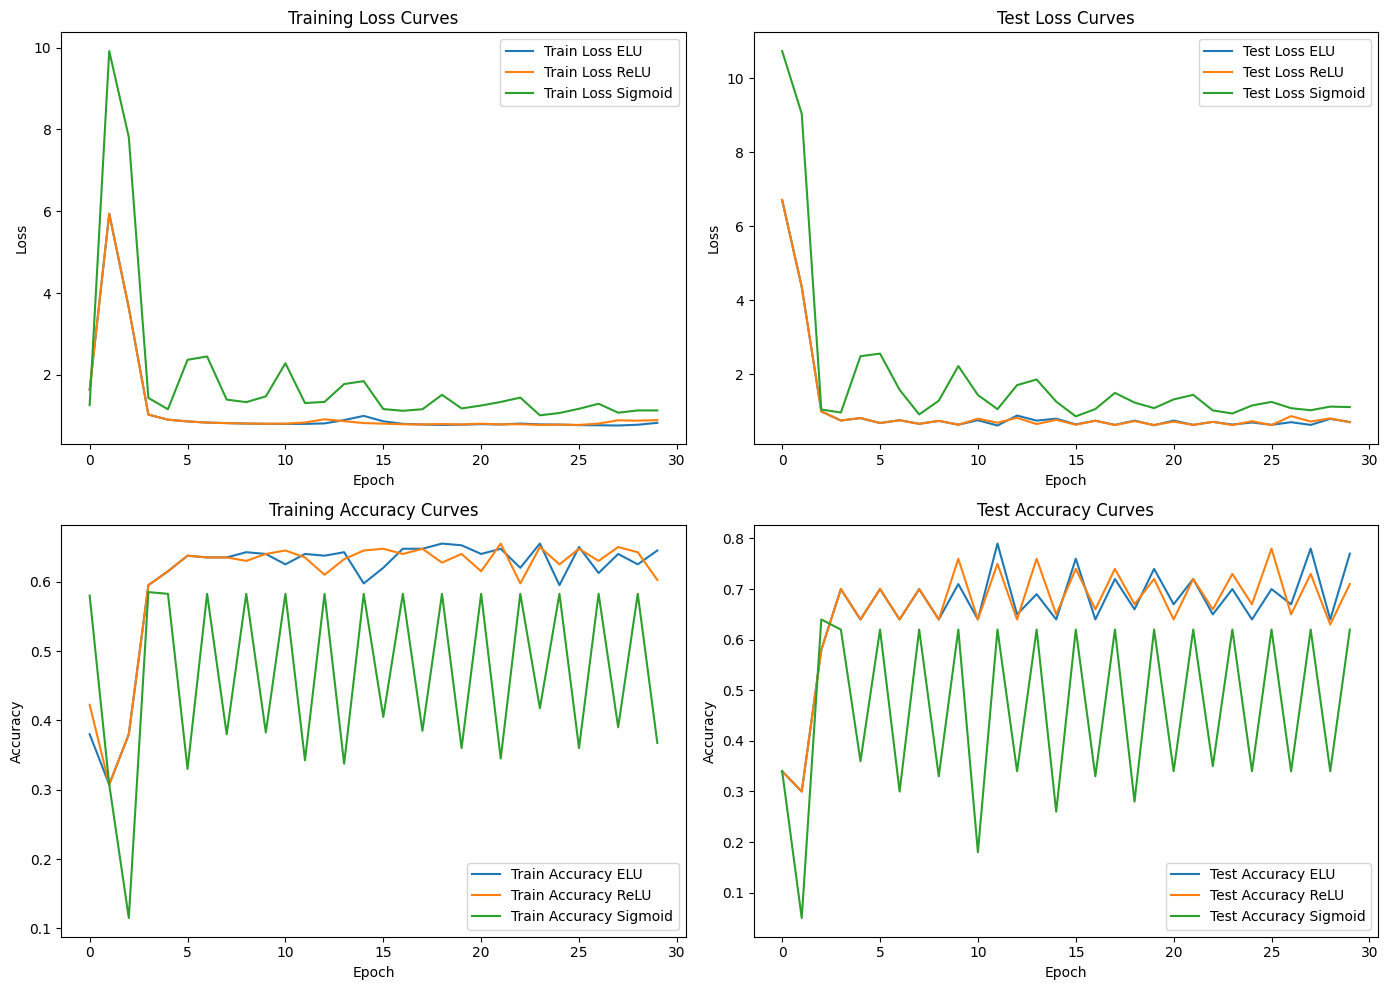

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

train_results_elu = pd.read_csv('results/activation/train_results_elu.csv')
test_results_elu = pd.read_csv('results/activation/test_results_elu.csv')

train_results_relu = pd.read_csv('results/activation/train_results_relu.csv')
test_results_relu = pd.read_csv('results/activation/test_results_relu.csv')

train_results_sigmoid = pd.read_csv('results/activation/train_results_sigmoid.csv')
test_results_sigmoid = pd.read_csv('results/activation/test_results_sigmoid.csv')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(train_results_elu['epoch'], train_results_elu['train_loss'], label='Train Loss ELU')
axes[0, 0].plot(train_results_relu['epoch'], train_results_relu['train_loss'], label='Train Loss ReLU')
axes[0, 0].plot(train_results_sigmoid['epoch'], train_results_sigmoid['train_loss'], label='Train Loss Sigmoid')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss Curves')
axes[0, 0].legend()

axes[0, 1].plot(test_results_elu['epoch'], test_results_elu['test_loss'], label='Test Loss ELU')
axes[0, 1].plot(test_results_relu['epoch'], test_results_relu['test_loss'], label='Test Loss ReLU')
axes[0, 1].plot(test_results_sigmoid['epoch'], test_results_sigmoid['test_loss'], label='Test Loss Sigmoid')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Test Loss Curves')
axes[0, 1].legend()

axes[1, 0].plot(train_results_elu['epoch'], train_results_elu['train_accuracy'], label='Train Accuracy ELU')
axes[1, 0].plot(train_results_relu['epoch'], train_results_relu['train_accuracy'], label='Train Accuracy ReLU')
axes[1, 0].plot(train_results_sigmoid['epoch'], train_results_sigmoid['train_accuracy'], label='Train Accuracy Sigmoid')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Training Accuracy Curves')
axes[1, 0].legend()

axes[1, 1].plot(test_results_elu['epoch'], test_results_elu['test_accuracy'], label='Test Accuracy ELU')
axes[1, 1].plot(test_results_relu['epoch'], test_results_relu['test_accuracy'], label='Test Accuracy ReLU')
axes[1, 1].plot(test_results_sigmoid['epoch'], test_results_sigmoid['test_accuracy'], label='Test Accuracy Sigmoid')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Test Accuracy Curves')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


### g2. Compare the performances of different learning rates.  (10 pts)
Comment on the result. 

*** As we can see from the below graphs, in this case the decreasing learning rate decreases the performance since the learning rates controls the velocity of the training. Since we are limited with 30 epochs decreasing learning rate will decrease the performance. ***

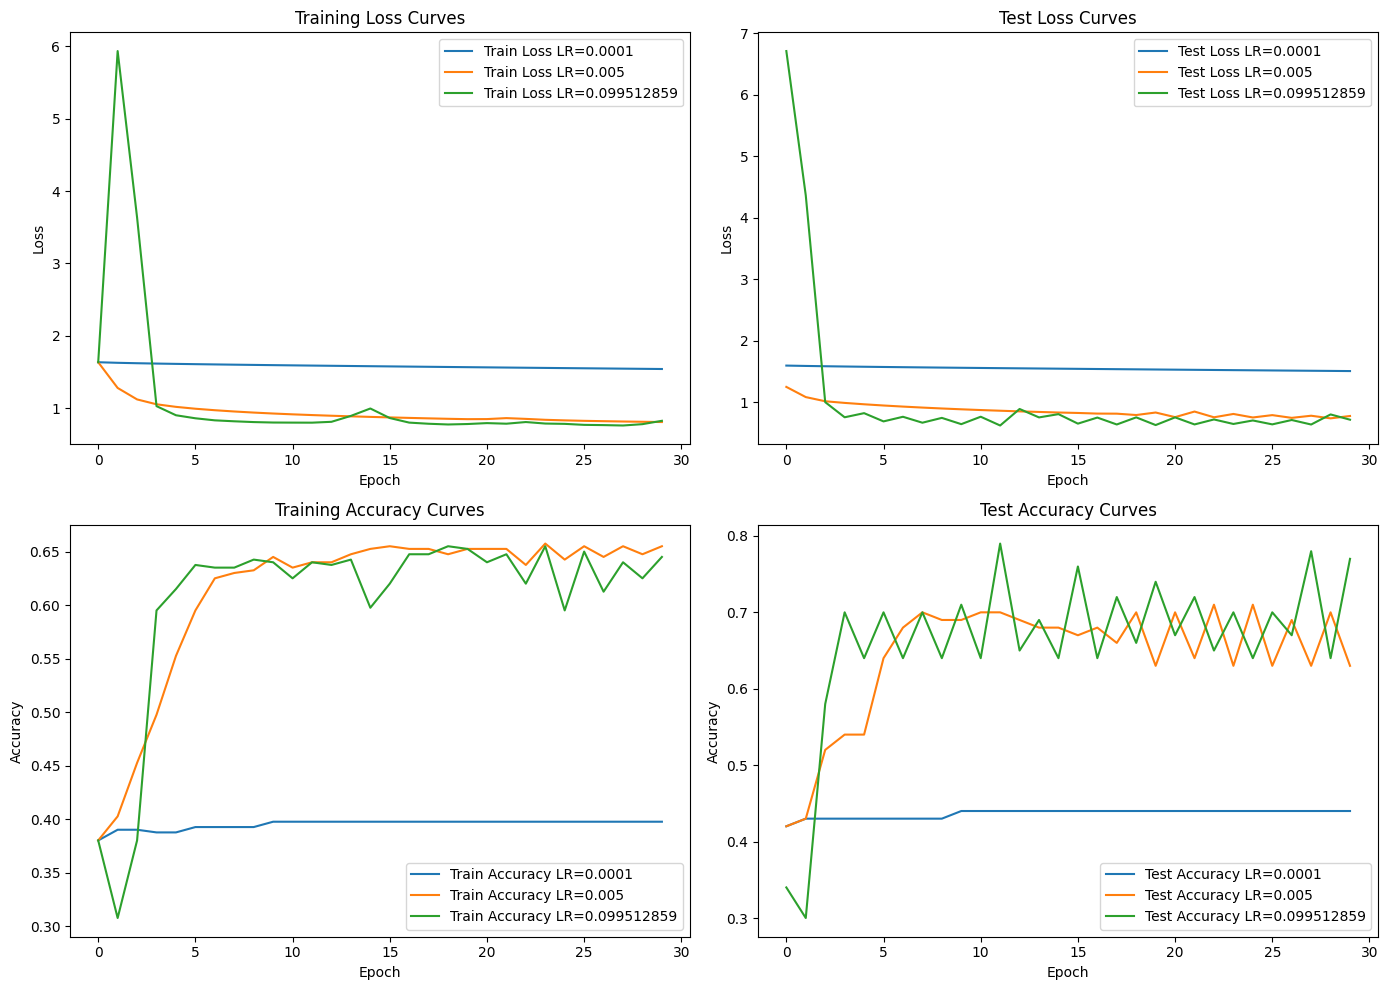

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

train_results_elu = pd.read_csv('results/lr/train_results_0.0001.csv')
test_results_elu = pd.read_csv('results/lr/test_results_0.0001.csv')

train_results_relu = pd.read_csv('results/lr/train_results_0.005.csv')
test_results_relu = pd.read_csv('results/lr/test_results_0.005.csv')

train_results_sigmoid = pd.read_csv('results/lr/train_results_0.09951285923544048.csv')
test_results_sigmoid = pd.read_csv('results/lr/test_results_0.09951285923544048.csv')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0, 0].plot(train_results_elu['epoch'], train_results_elu['train_loss'], label='Train Loss LR=0.0001')
axes[0, 0].plot(train_results_relu['epoch'], train_results_relu['train_loss'], label='Train Loss LR=0.005')
axes[0, 0].plot(train_results_sigmoid['epoch'], train_results_sigmoid['train_loss'], label='Train Loss LR=0.099512859')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training Loss Curves')
axes[0, 0].legend()

axes[0, 1].plot(test_results_elu['epoch'], test_results_elu['test_loss'], label='Test Loss LR=0.0001')
axes[0, 1].plot(test_results_relu['epoch'], test_results_relu['test_loss'], label='Test Loss LR=0.005')
axes[0, 1].plot(test_results_sigmoid['epoch'], test_results_sigmoid['test_loss'], label='Test Loss LR=0.099512859')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Test Loss Curves')
axes[0, 1].legend()

axes[1, 0].plot(train_results_elu['epoch'], train_results_elu['train_accuracy'], label='Train Accuracy LR=0.0001')
axes[1, 0].plot(train_results_relu['epoch'], train_results_relu['train_accuracy'], label='Train Accuracy LR=0.005')
axes[1, 0].plot(train_results_sigmoid['epoch'], train_results_sigmoid['train_accuracy'], label='Train Accuracy LR=0.099512859')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Training Accuracy Curves')
axes[1, 0].legend()

axes[1, 1].plot(test_results_elu['epoch'], test_results_elu['test_accuracy'], label='Test Accuracy LR=0.0001')
axes[1, 1].plot(test_results_relu['epoch'], test_results_relu['test_accuracy'], label='Test Accuracy LR=0.005')
axes[1, 1].plot(test_results_sigmoid['epoch'], test_results_sigmoid['test_accuracy'], label='Test Accuracy LR=0.099512859')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Test Accuracy Curves')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


### h. Plot the confusion Matrix (10 points)
Plot the confusion matrix and comment on the result (for your best result)

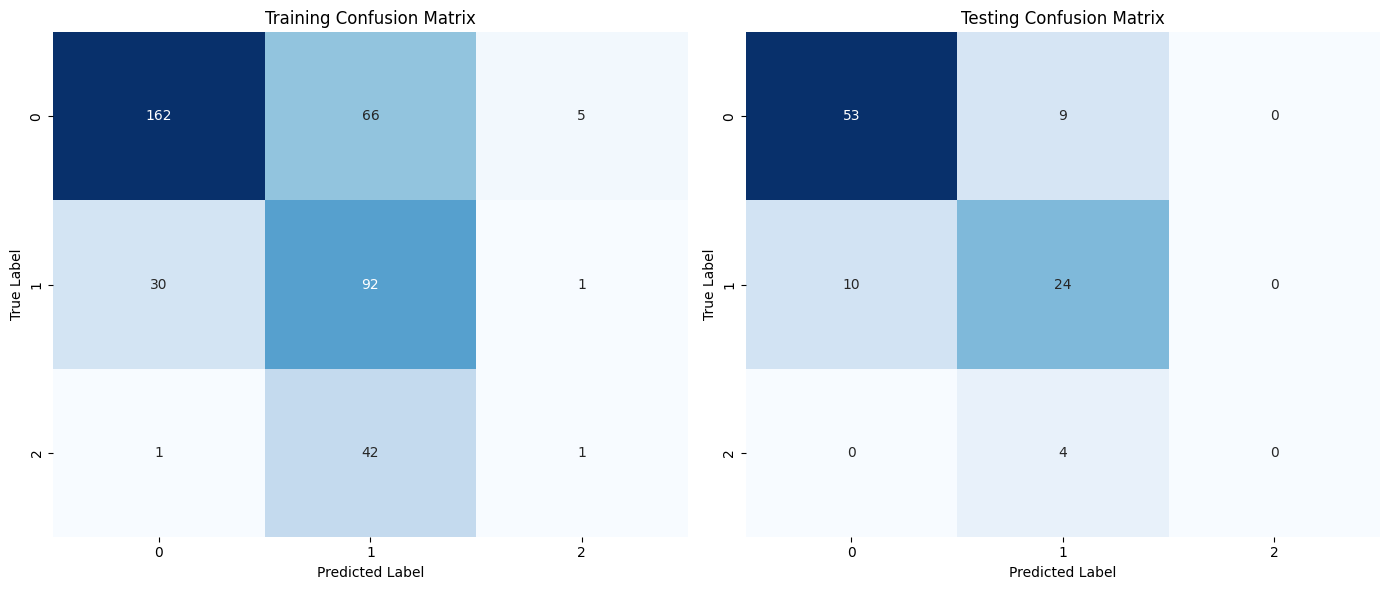

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

softmax_out_train = model.forward(X_train)
softmax_out_test = model.forward(X_test)

train_predictions = np.argmax(softmax_out_train, axis=1)
test_predictions = np.argmax(softmax_out_test, axis=1)

cm_train = confusion_matrix(y_train, train_predictions)
cm_test = confusion_matrix(y_test, test_predictions)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Training Confusion Matrix')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Testing Confusion Matrix')

plt.tight_layout()
plt.show()


### i. Plot the decision boundary (10 points)
Here, plot the decision boundary of your best result on the feature space. Revisit the feature pair scatter plot of your chosen feature pair. Highlight different classes using different classes and markers. 
Make sure you can identify training and testing datasets separately. Alternatively you can plot two different scatter plots. The classification boundaries are the points on feature (input) space where any two classes have equal (or near equal probability). Also highlight misclassified samples. 

/var/folders/40/p0p0x2hs1sbb5803zl4y5x8r0000gn/T/ipykernel_49611/2742421673.py:40: UserWarning: You passed a edgecolor/edgecolors ('r') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X[misclassified & (y_true == 0), 0], X[misclassified & (y_true == 0), 1], color='red',
/var/folders/40/p0p0x2hs1sbb5803zl4y5x8r0000gn/T/ipykernel_49611/2742421673.py:42: UserWarning: You passed a edgecolor/edgecolors ('r') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X[misclassified & (y_true == 1), 0], X[misclassified & (y_true == 1), 1], color='blue',
/var/folders/40/p0p0x2hs1sbb5803zl4y5x8r0000gn/T/ipykernel_49611/2742421673.py:44: UserWarning: You passed a edgecolor/edgecolors ('r') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may cha

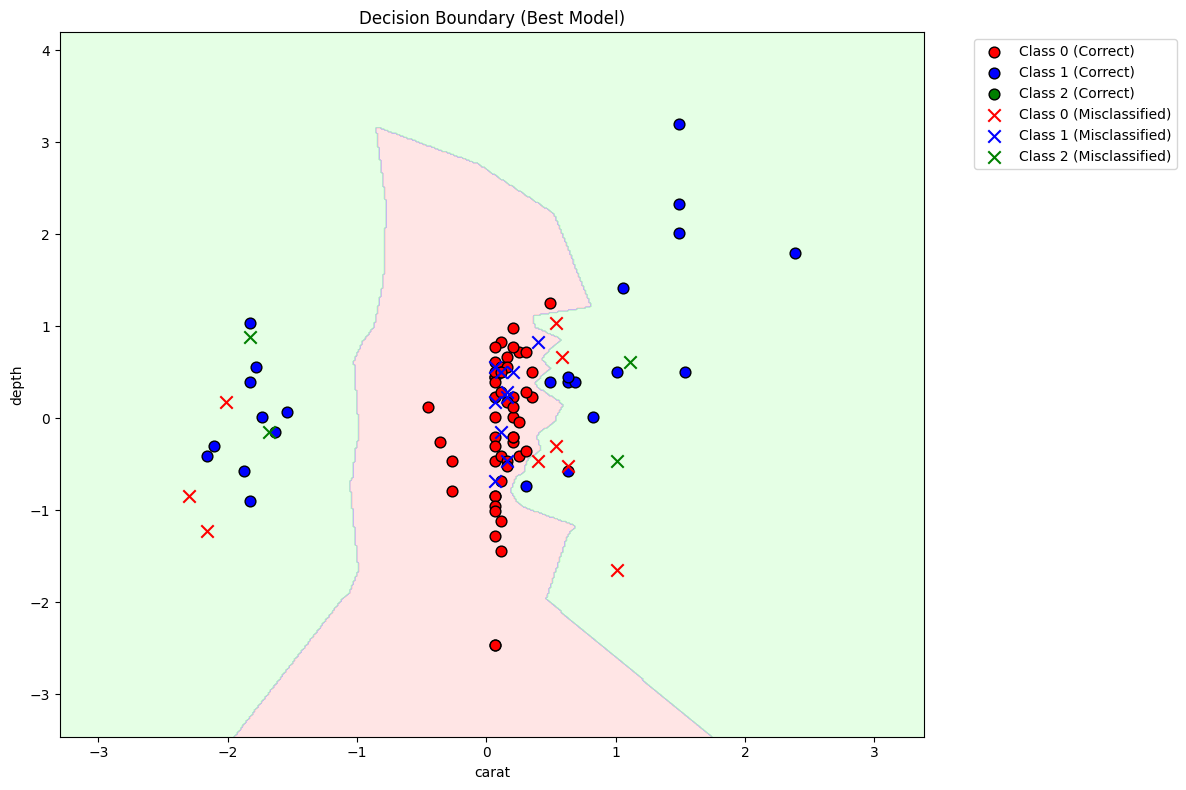

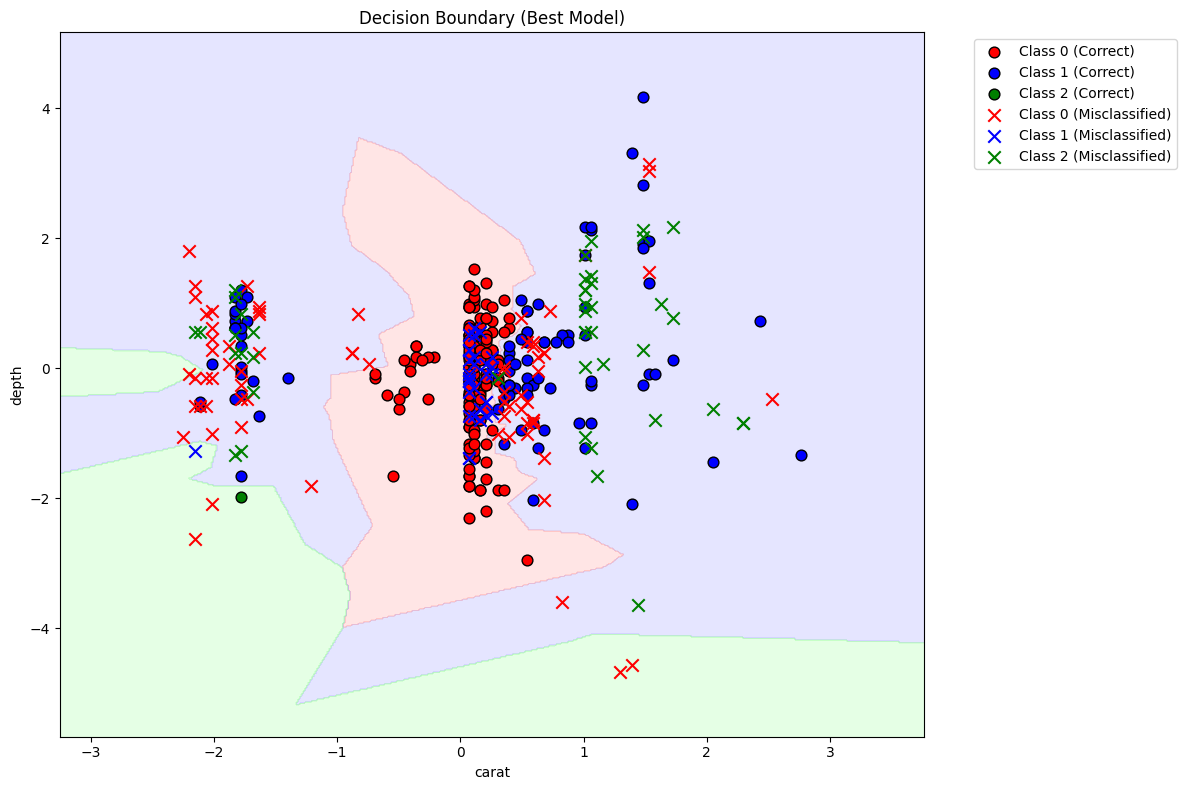

In [21]:
# Train neural network model and classifier
# (Assuming you have already trained the model and classifier)
# insert your code below


import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.colors import ListedColormap

def plot_decision_boundary(X, y_true, y_pred, title, f1='carat', f2='depth'):
    # Define the range of the mesh grid
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                        np.linspace(y_min, y_max, 500))

    # Interpolate predicted labels over the grid
    Z = griddata(X, y_pred, (xx, yy), method='nearest')

    # Define a color map for the three classes
    cmap = ListedColormap(['#FFAAAA', '#AAAAFF', '#AAFFAA'])

    # Plot decision boundary and data points
    plt.figure(figsize=(12, 8))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=cmap)  # Plot decision boundary for three classes

    # Identify misclassified samples
    misclassified = (y_true != y_pred)

    # Plot correctly classified points for each class
    plt.scatter(X[~misclassified & (y_true == 0), 0], X[~misclassified & (y_true == 0), 1], color='red', 
                marker='o', label='Class 0 (Correct)', s=60, edgecolor='k')
    plt.scatter(X[~misclassified & (y_true == 1), 0], X[~misclassified & (y_true == 1), 1], color='blue', 
                marker='o', label='Class 1 (Correct)', s=60, edgecolor='k')
    plt.scatter(X[~misclassified & (y_true == 2), 0], X[~misclassified & (y_true == 2), 1], color='green', 
                marker='o', label='Class 2 (Correct)', s=60, edgecolor='k')

    # Plot misclassified points for each class
    plt.scatter(X[misclassified & (y_true == 0), 0], X[misclassified & (y_true == 0), 1], color='red', 
                marker='x', label='Class 0 (Misclassified)', s=80, edgecolor='r')
    plt.scatter(X[misclassified & (y_true == 1), 0], X[misclassified & (y_true == 1), 1], color='blue', 
                marker='x', label='Class 1 (Misclassified)', s=80, edgecolor='r')
    plt.scatter(X[misclassified & (y_true == 2), 0], X[misclassified & (y_true == 2), 1], color='green', 
                marker='x', label='Class 2 (Misclassified)', s=80, edgecolor='r')

    # Additional plot settings
    plt.xlabel(f1)
    plt.ylabel(f2)
    plt.title(title)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)
    plt.tight_layout()
    plt.show()

softmax_out_train = model.forward(X_train)
softmax_out_test = model.forward(X_test)

train_predictions = np.argmax(softmax_out_train, axis=1)
test_predictions = np.argmax(softmax_out_test, axis=1)

plot_decision_boundary(X_test.copy() , y_test.copy() , test_predictions, "Decision Boundary (Best Model)")


plot_decision_boundary(X_train.copy() , y_train.copy() , train_predictions, "Decision Boundary (Best Model)")


### k. Comment how does using different activation functions affect decision boundary? (5pts)

*** Activation functions directyl effects the decision boundar. For instance the sigmoid tries to draw a linear line between two instances in this example it decides the not drawing line it predict only one label since it is not trained too much. On the other hande, ELU and RELU similar decision boundaries with small differences. ELU is more sensitive ***

/var/folders/40/p0p0x2hs1sbb5803zl4y5x8r0000gn/T/ipykernel_49611/2742421673.py:40: UserWarning: You passed a edgecolor/edgecolors ('r') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X[misclassified & (y_true == 0), 0], X[misclassified & (y_true == 0), 1], color='red',
/var/folders/40/p0p0x2hs1sbb5803zl4y5x8r0000gn/T/ipykernel_49611/2742421673.py:42: UserWarning: You passed a edgecolor/edgecolors ('r') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X[misclassified & (y_true == 1), 0], X[misclassified & (y_true == 1), 1], color='blue',
/var/folders/40/p0p0x2hs1sbb5803zl4y5x8r0000gn/T/ipykernel_49611/2742421673.py:44: UserWarning: You passed a edgecolor/edgecolors ('r') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may cha

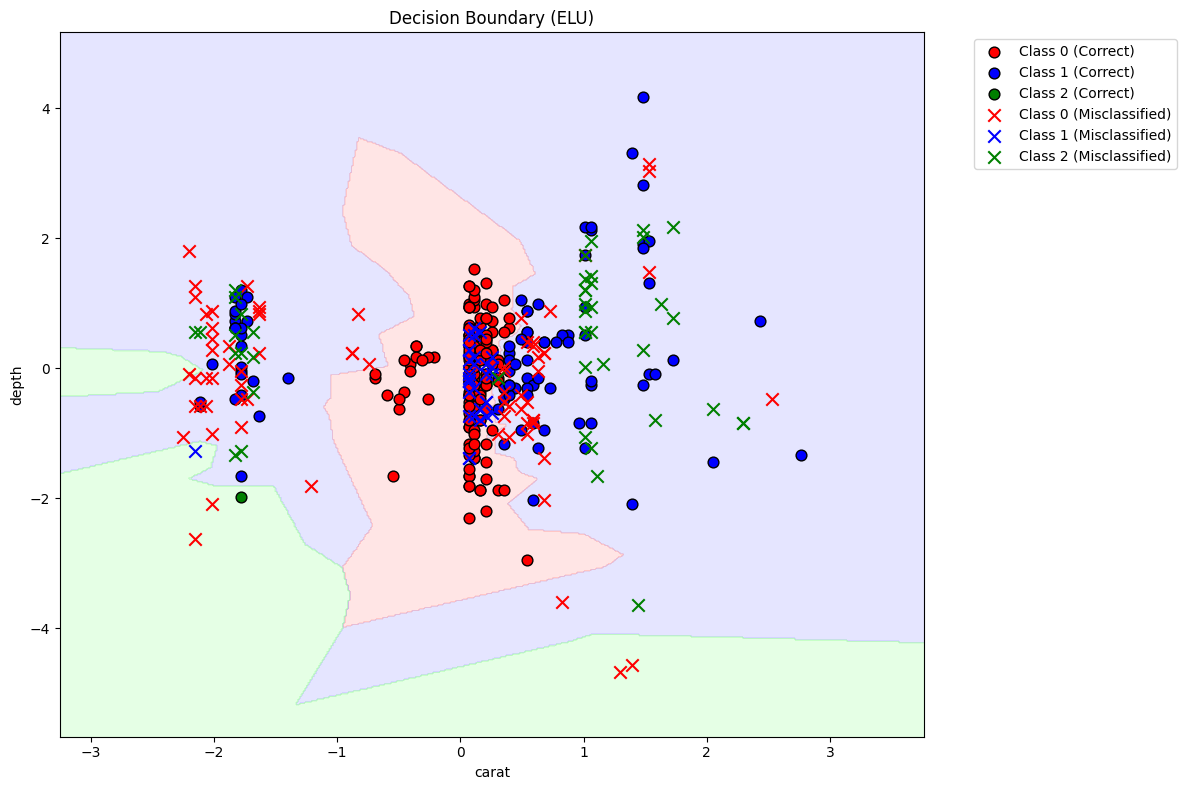

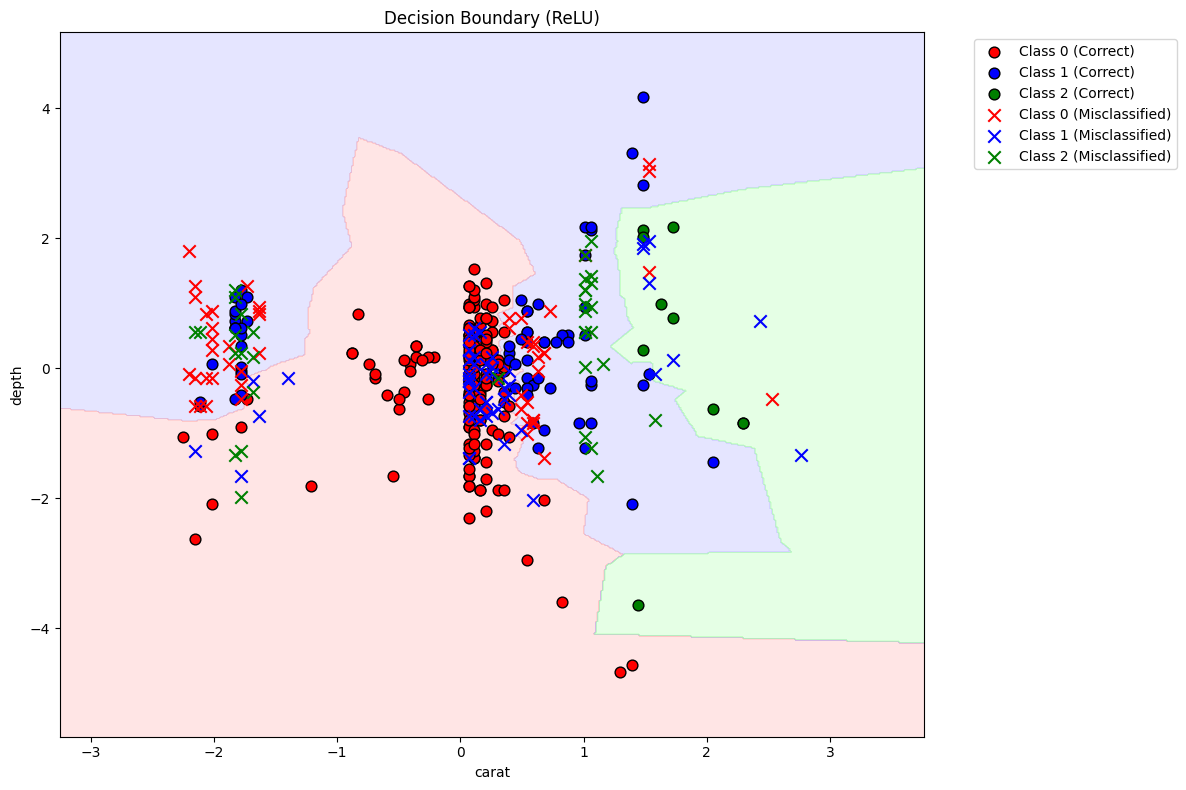

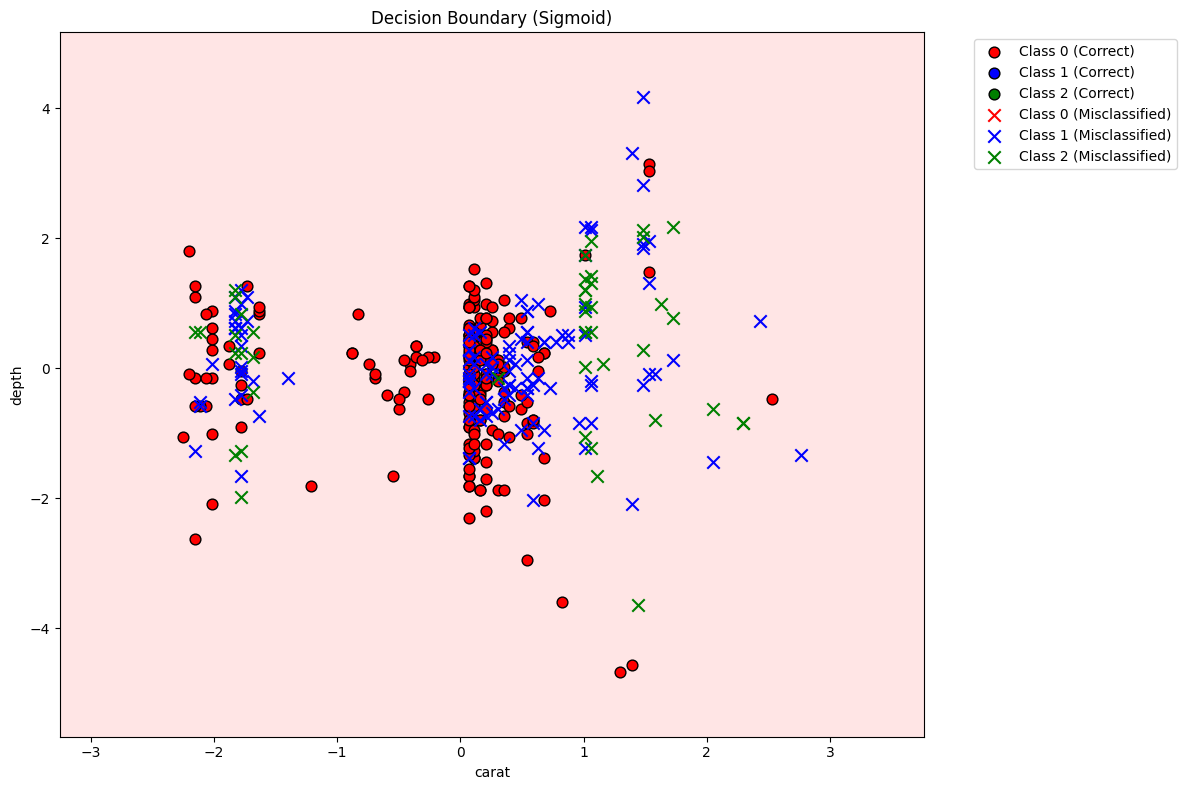

In [24]:
# show some plots and comment on them. 
activation_results_elu = pd.read_csv('results/activation/activations_elu_results.csv')
activation_results_relu = pd.read_csv('results/activation/activations_relu_results.csv')
activation_results_sigmoid = pd.read_csv('results/activation/activations_sigmoid_results.csv')

plot_decision_boundary(X_train.copy() , y_train.copy() , activation_results_elu['predictions_train'], "Decision Boundary (ELU)")
plot_decision_boundary(X_train.copy() , y_train.copy() , activation_results_relu['predictions_train'], "Decision Boundary (ReLU)")
plot_decision_boundary(X_train.copy() , y_train.copy() , activation_results_sigmoid['predictions_train'], "Decision Boundary (Sigmoid)")


### l. Original diamonds dataset can also be classified according to different categories: cut and clarity. Which label is easier to classify for your model?  (15 pts)

Change the filtering to create different subsets with different labels, "here". Filter the subset to have three classes, 500 samples and 2 features per sample. Then, classify the samples. Comment on the results.

*** I choose thhe features as table and depth and target variable as cut. I reached .86 accuracy easliy. Since the new features and target easliy be clustered. Plots shows the results ***

In [25]:
diamonds = sns.load_dataset("diamonds")

diamonds.nunique()

carat        273
cut            5
color          7
clarity        8
depth        184
table        127
price      11602
x            554
y            552
z            375
dtype: int64

In [26]:
diamonds['cut'].value_counts()

Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int64

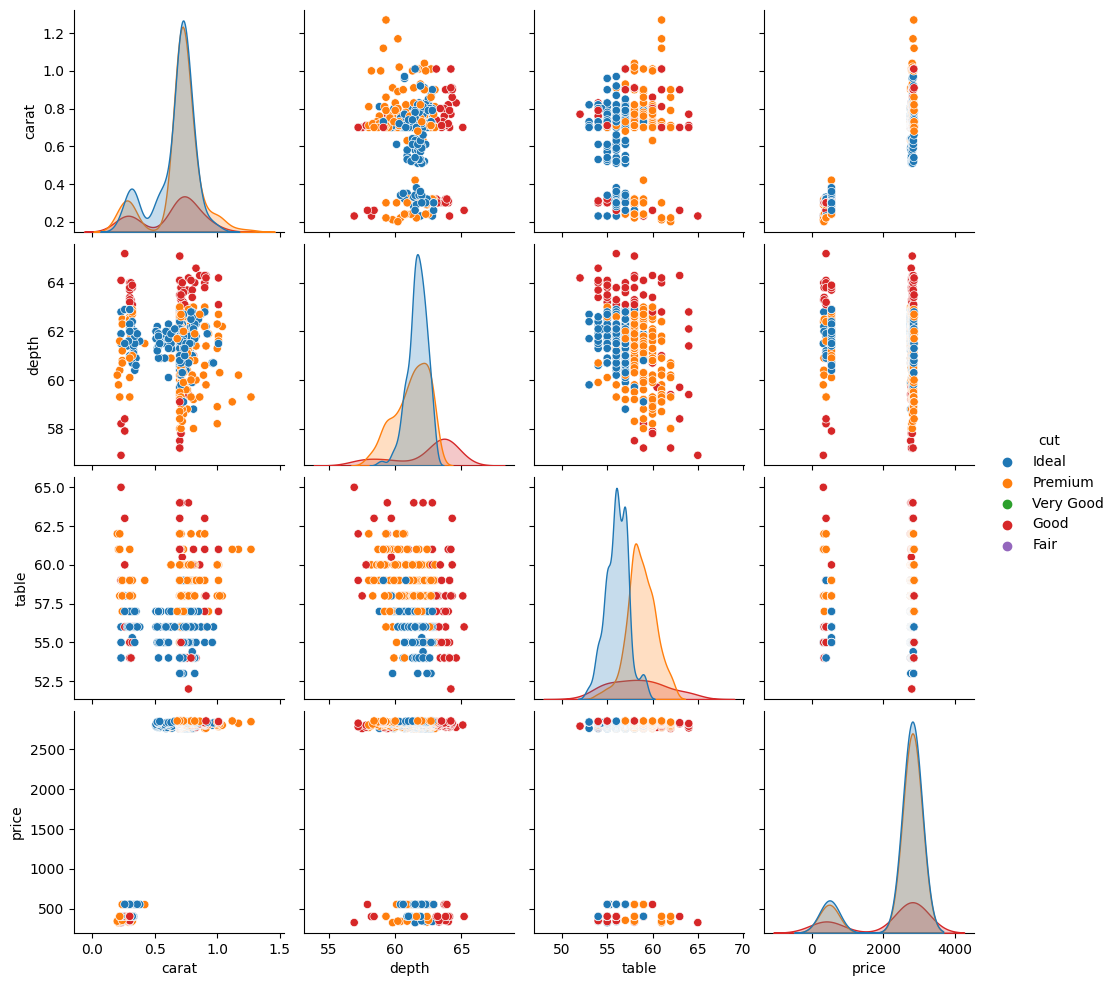

In [27]:
# create a subset
diamonds_filtered2 = (diamonds[diamonds['cut'].isin(['Ideal', 'Premium', 'Good'])]).iloc[:500]
diamonds_filtered2 = diamonds_filtered2[['carat','depth', 'table', 'color', 'price', 'cut']]
sns.pairplot(diamonds_filtered2, hue='cut')

In [28]:
diamonds['clarity'].value_counts()


SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: clarity, dtype: int64

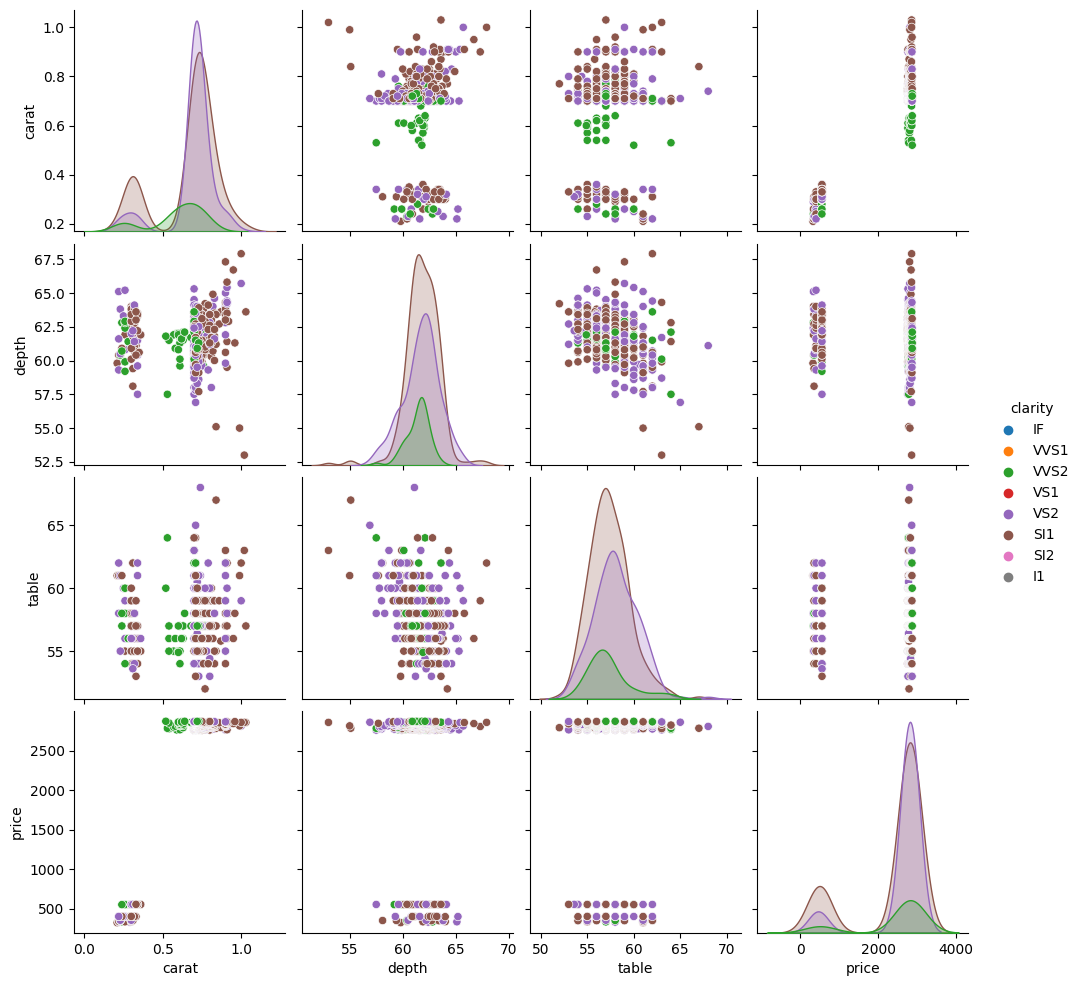

In [29]:
# create a subset
diamonds_filtered3 = (diamonds[diamonds['clarity'].isin(['SI1', 'VS2', 'VVS2'])]).iloc[:500]
diamonds_filtered3 = diamonds_filtered3[['carat','depth', 'table', 'color', 'price', 'clarity']]
sns.pairplot(diamonds_filtered3, hue='clarity')

(400, 2) (400,)
TRAIN:	Epoch:   0, Loss: 1.47007, Accuracy: 0.36750
TEST:	Epoch:   0, Loss: 2.75278, Accuracy: 0.65000
TRAIN:	Epoch:   1, Loss: 2.82618, Accuracy: 0.71000
TEST:	Epoch:   1, Loss: 2.55426, Accuracy: 0.50000
TRAIN:	Epoch:   2, Loss: 2.18254, Accuracy: 0.56250
TEST:	Epoch:   2, Loss: 1.68181, Accuracy: 0.70000
TRAIN:	Epoch:   3, Loss: 1.38350, Accuracy: 0.73750
TEST:	Epoch:   3, Loss: 0.72826, Accuracy: 0.78000
TRAIN:	Epoch:   4, Loss: 0.69548, Accuracy: 0.77750
TEST:	Epoch:   4, Loss: 0.69771, Accuracy: 0.79000
TRAIN:	Epoch:   5, Loss: 0.63205, Accuracy: 0.82500
TEST:	Epoch:   5, Loss: 0.60859, Accuracy: 0.77000
TRAIN:	Epoch:   6, Loss: 0.57362, Accuracy: 0.82500
TEST:	Epoch:   6, Loss: 0.74031, Accuracy: 0.81000
TRAIN:	Epoch:   7, Loss: 0.62062, Accuracy: 0.82000
TEST:	Epoch:   7, Loss: 0.65132, Accuracy: 0.71000
TRAIN:	Epoch:   8, Loss: 0.62371, Accuracy: 0.73500
TEST:	Epoch:   8, Loss: 0.87046, Accuracy: 0.77000
TRAIN:	Epoch:   9, Loss: 0.71847, Accuracy: 0.80750
TEST:

/var/folders/40/p0p0x2hs1sbb5803zl4y5x8r0000gn/T/ipykernel_49611/2742421673.py:40: UserWarning: You passed a edgecolor/edgecolors ('r') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X[misclassified & (y_true == 0), 0], X[misclassified & (y_true == 0), 1], color='red',
/var/folders/40/p0p0x2hs1sbb5803zl4y5x8r0000gn/T/ipykernel_49611/2742421673.py:42: UserWarning: You passed a edgecolor/edgecolors ('r') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X[misclassified & (y_true == 1), 0], X[misclassified & (y_true == 1), 1], color='blue',
/var/folders/40/p0p0x2hs1sbb5803zl4y5x8r0000gn/T/ipykernel_49611/2742421673.py:44: UserWarning: You passed a edgecolor/edgecolors ('r') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may cha

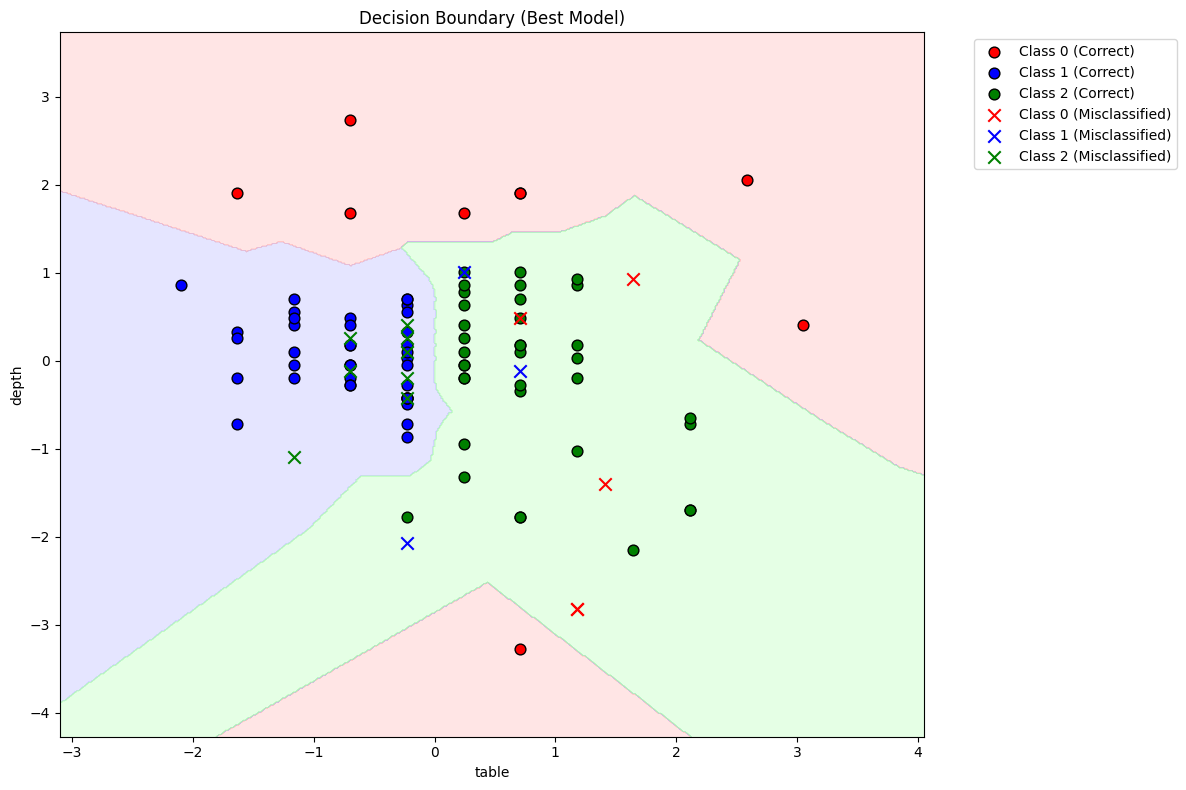

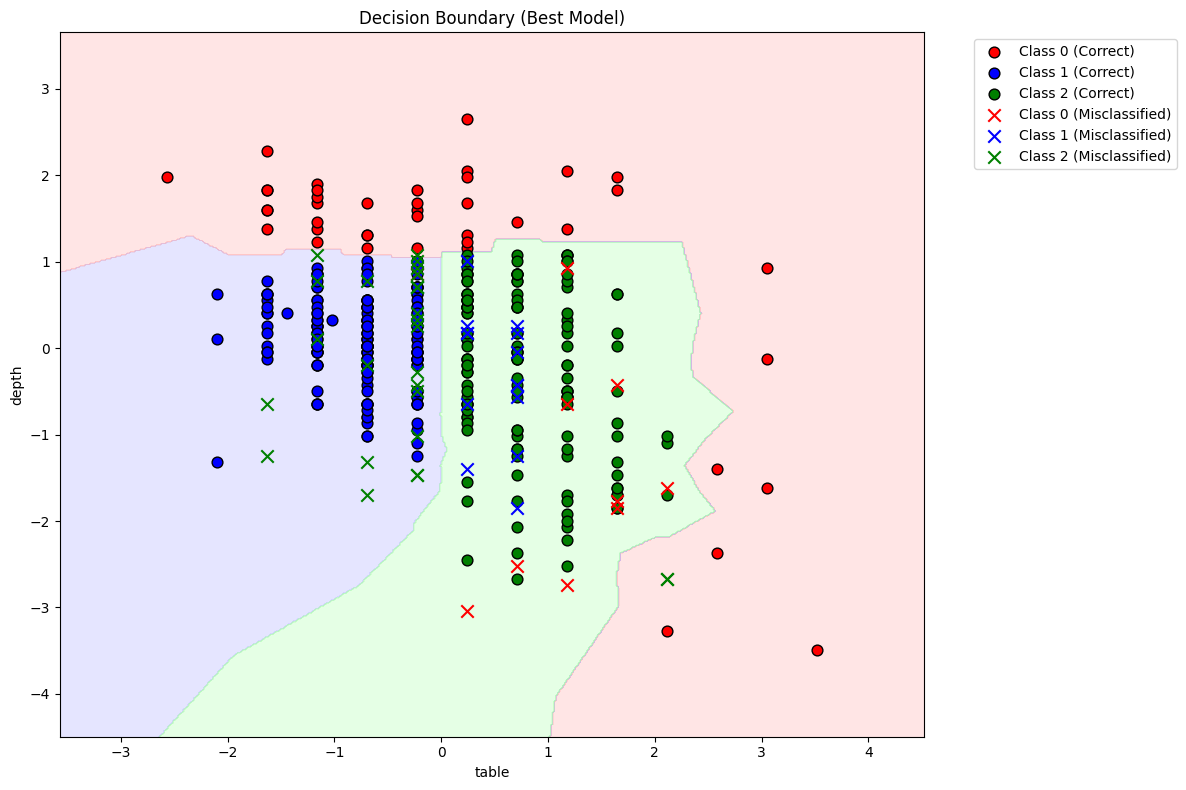

In [30]:
data = diamonds_filtered2.copy()

data = data.dropna()

le = preprocessing.LabelEncoder()
data['cut'] = le.fit_transform(data['cut'])

X = data[['table', 'depth']].values
y = data['cut'].values

import pandas as pd


model = bases.Model()  # Create a model instance


model_layers = [
    layers.AffineLayer(2, 64, seed=1773),
    activations.ExponentialLinearUnit(),
    layers.AffineLayer(64, 3, seed=1773),
    classifiers.Softmax(),
]  


model(model_layers)  # Load layers to model object
predictions = np.ones(y.shape[0])  # Number of instances in the diamonds data
train_accs = []
test_accs = []
train_losses = []
test_losses = []


# Shuffle dataset
def create_permutation(x, y):
    perm = np.random.permutation(len(x))
    return x[perm], y[perm]


def train_test_split(X, y, ratio=0.2):
    X, y = create_permutation(X, y)
    split_index = int(len(X) * (1 - ratio))
    X_train, y_train = X[:split_index], y[:split_index]
    X_test, y_test = X[split_index:], y[split_index:]
    return X_train, y_train, X_test, y_test


# Options
preprocessing_on = True
shuffle_on_each_epoch = True
regularization_strength = 0.01
n_epochs = 30
train_test_split_ratio = 0.2
print_every = 1
test_every = 1
test_points = []
if preprocessing_on:
    X = preprocessing.scale(X)
X_train, y_train, X_test, y_test = train_test_split(X, y)
print(X_train.shape, y_train.shape)

optimizer = optimizers.RMSprop(model=model, lr=0.09951285923544048, epsilon=3.7770389463452032e-06)



for epoch in range(n_epochs):
    if shuffle_on_each_epoch:
        X_train, y_train = create_permutation(X_train, y_train)

    # COMPLETE THE CODE BELOW

    softmax_out = model.forward(X_train)

    predictions = np.argmax(softmax_out, axis=1)
    loss = losses.loss(softmax_out, y_train)
    train_acc = np.mean(predictions == y_train)
    train_accs.append(train_acc)
    train_losses.append(loss)

    if epoch % print_every == 0:
        print(f"TRAIN:\tEpoch: {epoch:3d}, Loss: {loss:.5f}, Accuracy: {train_acc:.5f}")

    # call backpropagation
    model.backward(y_train)
    optimizer.optimize()

    # Then complete the testing part.
    if epoch % test_every == 0 or epoch == n_epochs - 1:
        softmax_out = model.forward(X_test)
        predictions = np.argmax(softmax_out, axis=1)
        loss = losses.loss(softmax_out, y_test)
        test_acc = np.mean(predictions == y_test)
        test_losses.append(loss)
        test_points.append(epoch)
        test_accs.extend([test_acc for i in range(test_every)])
        print(f"TEST:\tEpoch: {epoch:3d}, Loss: {loss:.5f}, Accuracy: {test_acc:.5f}")

softmax_out_train = model.forward(X_train)
softmax_out_test = model.forward(X_test)

train_predictions = np.argmax(softmax_out_train, axis=1)
test_predictions = np.argmax(softmax_out_test, axis=1)

plot_decision_boundary(X_test.copy() , y_test.copy() , test_predictions, "Decision Boundary (Best Model)", 'table', 'depth')
plot_decision_boundary(X_train.copy() , y_train.copy() , train_predictions, "Decision Boundary (Best Model)", 'table', 'depth')




## 3. Pytorch (15 pts)
#### Repeat the model construction and training/testing (.f) with Pytorch layers and activations and optimizers. 

torch.Size([400, 2]) torch.Size([400])
TRAIN:	Epoch:   0, Loss: 1.10445, Accuracy: 0.30500
TEST:	Epoch:   0, Loss: 0.98127, Accuracy: 0.57000
TRAIN:	Epoch:   1, Loss: 0.95504, Accuracy: 0.59500
TEST:	Epoch:   1, Loss: 1.01214, Accuracy: 0.54000
TRAIN:	Epoch:   2, Loss: 0.98866, Accuracy: 0.56250
TEST:	Epoch:   2, Loss: 0.94144, Accuracy: 0.61000
TRAIN:	Epoch:   3, Loss: 0.93370, Accuracy: 0.61750
TEST:	Epoch:   3, Loss: 0.93779, Accuracy: 0.61000
TRAIN:	Epoch:   4, Loss: 0.92526, Accuracy: 0.62500
TEST:	Epoch:   4, Loss: 0.90250, Accuracy: 0.65000
TRAIN:	Epoch:   5, Loss: 0.89909, Accuracy: 0.65500
TEST:	Epoch:   5, Loss: 0.92206, Accuracy: 0.63000
TRAIN:	Epoch:   6, Loss: 0.89421, Accuracy: 0.65500
TEST:	Epoch:   6, Loss: 0.92129, Accuracy: 0.63000
TRAIN:	Epoch:   7, Loss: 0.88828, Accuracy: 0.66000
TEST:	Epoch:   7, Loss: 0.96163, Accuracy: 0.59000
TRAIN:	Epoch:   8, Loss: 0.93723, Accuracy: 0.60750
TEST:	Epoch:   8, Loss: 0.93177, Accuracy: 0.62000
TRAIN:	Epoch:   9, Loss: 0.89085, 

/var/folders/40/p0p0x2hs1sbb5803zl4y5x8r0000gn/T/ipykernel_49611/2742421673.py:40: UserWarning: You passed a edgecolor/edgecolors ('r') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X[misclassified & (y_true == 0), 0], X[misclassified & (y_true == 0), 1], color='red',
/var/folders/40/p0p0x2hs1sbb5803zl4y5x8r0000gn/T/ipykernel_49611/2742421673.py:42: UserWarning: You passed a edgecolor/edgecolors ('r') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X[misclassified & (y_true == 1), 0], X[misclassified & (y_true == 1), 1], color='blue',
/var/folders/40/p0p0x2hs1sbb5803zl4y5x8r0000gn/T/ipykernel_49611/2742421673.py:44: UserWarning: You passed a edgecolor/edgecolors ('r') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may cha

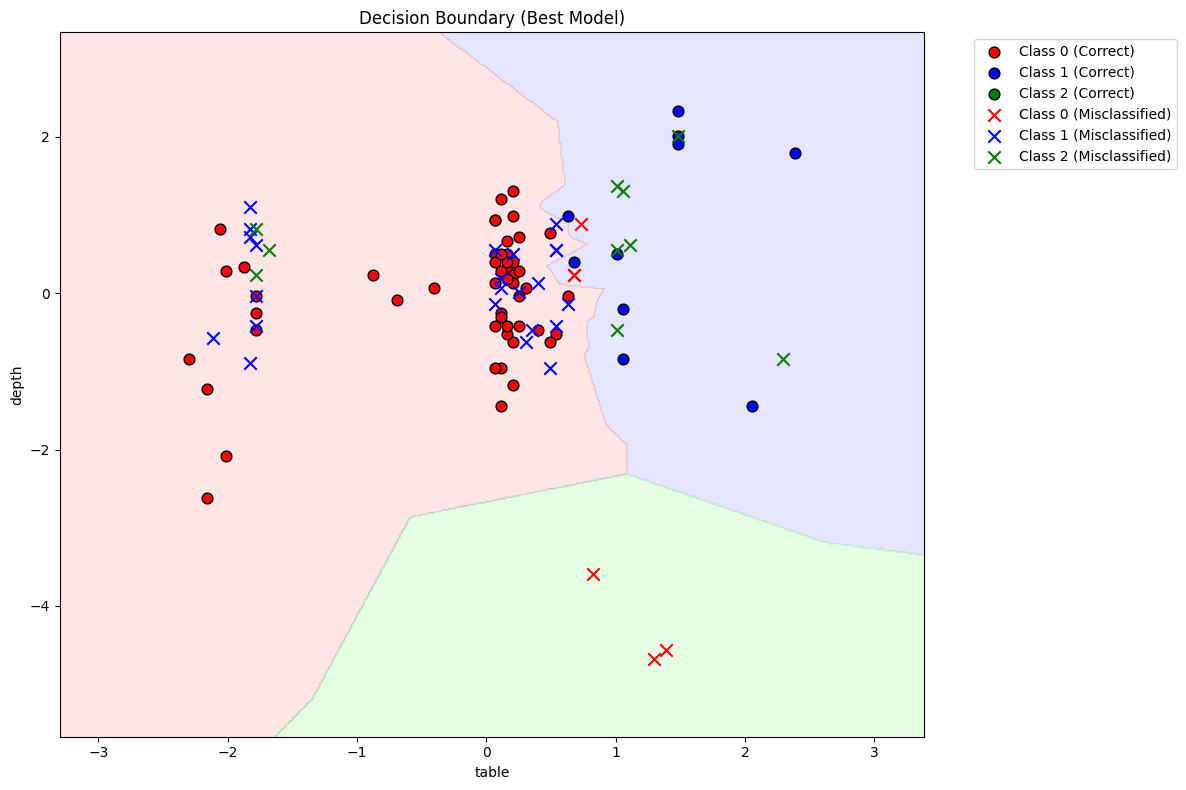

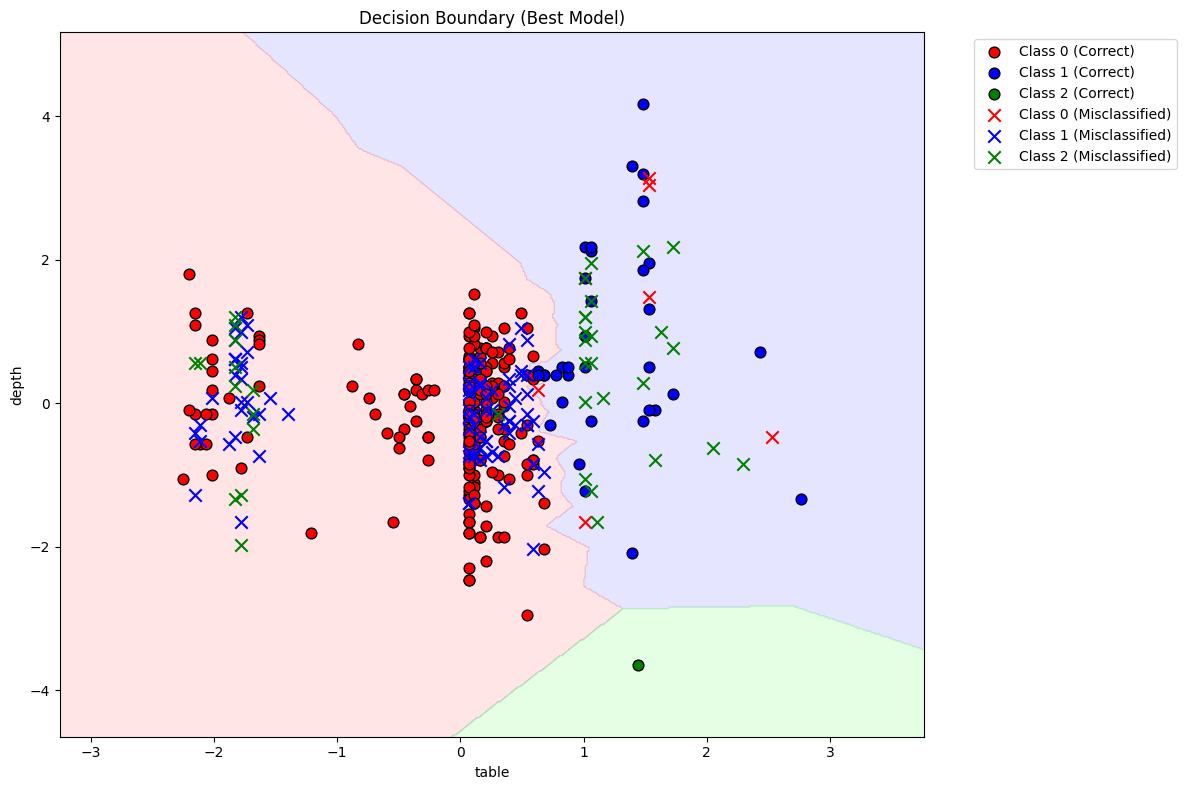

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim

diamonds = sns.load_dataset("diamonds")

# create a subset
diamonds_filtered = (diamonds[diamonds['color'].isin(['E', 'J', 'H'])]).iloc[:500]
diamonds_filtered = diamonds_filtered[['carat','depth', 'table', 'color', 'price']]


data = diamonds_filtered.copy()

data = data.dropna()

le = preprocessing.LabelEncoder()
data['color'] = le.fit_transform(data['color'])

X = data[['carat', 'depth']].values
y = data['color'].values

torch.manual_seed(1773)
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
        self.elu = nn.ELU()
    def forward(self, x):
        x = self.elu(self.l1(x))
        x = self.softmax(self.l2(x))
        return x
    
model = Model(2, 64, 3)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.RMSprop(model.parameters(), lr=0.07, eps=3.7770389463452032e-06)


predictions = np.ones(y.shape[0])  # Number of instances in the diamonds data
train_accs = []
test_accs = []
train_losses = []
test_losses = []


# Shuffle dataset
def create_permutation(x, y):
    perm = np.random.permutation(len(x))
    return x[perm], y[perm]


def train_test_split(X, y, ratio=0.2):
    X, y = create_permutation(X, y)
    split_index = int(len(X) * (1 - ratio))
    X_train, y_train = X[:split_index], y[:split_index]
    X_test, y_test = X[split_index:], y[split_index:]
    return X_train, y_train, X_test, y_test


# Options
preprocessing_on = True
shuffle_on_each_epoch = True
regularization_strength = 0.01
n_epochs = 30
train_test_split_ratio = 0.2
print_every = 1
test_every = 1
test_points = []
if preprocessing_on:
    X = preprocessing.scale(X)
X_train, y_train, X_test, y_test = train_test_split(X, y)
X_train, y_train, X_test, y_test = torch.tensor(X_train).float(), torch.tensor(y_train).long(), torch.tensor(X_test).float(), torch.tensor(y_test).long()
print(X_train.shape, y_train.shape)


for epoch in range(n_epochs):
    if shuffle_on_each_epoch:
        X_train, y_train = create_permutation(X_train, y_train)

    # COMPLETE THE CODE BELOW

    softmax_out = model.forward(X_train)
    predictions = np.argmax(softmax_out.detach().numpy(), axis=1)
    loss = criterion(softmax_out, y_train)
    train_acc = np.mean(predictions == y_train.detach().numpy())
    train_accs.append(train_acc)
    train_losses.append(loss)

    if epoch % print_every == 0:
        print(f"TRAIN:\tEpoch: {epoch:3d}, Loss: {loss:.5f}, Accuracy: {train_acc:.5f}")

    optimizer.zero_grad()
    # call backpropagation
    loss.backward()
    optimizer.step()

    # Then complete the testing part.
    if epoch % test_every == 0 or epoch == n_epochs - 1:
        softmax_out = model.forward(X_test)
        predictions = np.argmax(softmax_out.detach().numpy(), axis=1)
        loss = criterion(softmax_out, y_test)
        test_acc = np.mean(predictions == y_test.detach().numpy())
        test_losses.append(loss)
        test_points.append(epoch)
        test_accs.extend([test_acc for i in range(test_every)])
        print(f"TEST:\tEpoch: {epoch:3d}, Loss: {loss:.5f}, Accuracy: {test_acc:.5f}")

softmax_out_train = model.forward(X_train)
softmax_out_test = model.forward(X_test)

train_predictions = np.argmax(softmax_out_train.detach().numpy(), axis=1)
test_predictions = np.argmax(softmax_out_test.detach().numpy() , axis=1)

plot_decision_boundary(X_test.detach().numpy().copy() , y_test.detach().numpy().copy() , test_predictions, "Decision Boundary (Best Model)", 'table', 'depth')
plot_decision_boundary(X_train.detach().numpy().copy() , y_train.detach().numpy().copy() , train_predictions, "Decision Boundary (Best Model)", 'table', 'depth')


